# Section 1: Import Stuff

Import necessary packages

In [6]:
import matplotlib
%matplotlib inline
import pickle
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import scipy.constants
import matplotlib.pyplot as plt
import pandas as pd
params = {'xtick.major.size':6,'xtick.minor.size':3,'ytick.major.size':6,'ytick.minor.size':3,'xtick.major.width':0.5,'ytick.major.width':0.5,'xtick.minor.width':0.5,'ytick.minor.width':0.5}

plt.rcParams.update(params)

params = {'backend': 'pdf',
        'axes.labelsize': 14,
        'lines.markersize': 6,
        'font.size': 14,
        'xtick.major.size':8,
        'xtick.minor.size':4,
        'ytick.major.size':8,
        'ytick.minor.size':4,
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'savefig.dpi':400,
        'path.simplify':True
         }
plt.rcParams.update(params)

# Section 2: Load and Clean Dynamic Spectrum

The purpose of the next few cells is to load a dynamic spectrum
pickle file to check for how many arcs you should 
expect to be able to fit. This extra step
is necessary because the arcs are a lot clearer
when viewed this way than when using `scintools`, 
so it's a good idea to check here first.

Choose a .pickle file to load

In [7]:
pickle_file = '../../60098_files/60098_325.0244140625_9.99948288_sum_temp_match_rfi_cleaned.pickle'

with open(pickle_file, 'rb') as f:
    pklload = pickle.load(f)

Modify variables based on whether the file name has `rfi_cleaned` in the name

In [8]:
if pickle_file.split('_')[-1].split('.')[0] in ['standard']:
    clean = False
else:
    clean = True
if clean:
    rfi_cleaned = 'rfi_cleaned'
else:
    rfi_cleaned = 'standard'

Load parameters and dynamic spectrum from pickle file. Parameter `a` is the dynamic spectrum

In [9]:
mjd = pklload[0]
a = pklload[4]
bw = pklload[2]
subint = pklload[3]
cfreq = pklload[1]
freq_main = cfreq
t_int = subint
BW = bw
a = np.flipud(a)

Check the dynamic spectrum

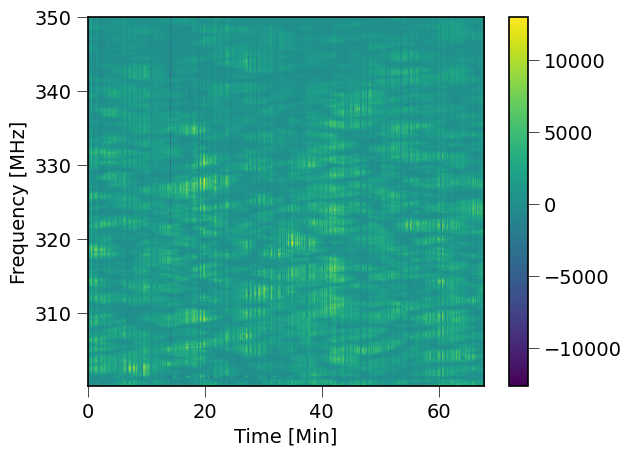

In [10]:
plt.imshow(a,aspect = 'auto', extent = [0.0, subint*a.shape[1]/60, cfreq-(bw/2),cfreq+bw/2]);
plt.xlabel("Time [Min]")
plt.ylabel("Frequency [MHz]")
plt.colorbar(); 
plt.show()

Modify the dynamic spectrum variable `a` to see how many values in the array are greater 
or less than positive or negative pixel value limits you've set.
I would say once you reach printed values greater than 
around 300-500 pixels you should stop trying to make the spectrum look
clearer, but that's definitely not a hard cutoff (it's ok to be a little lazy with this). There are also some epochs that you may need to remove a lot more pixels before anything is visible, and in those cases removing negative values up to around zero may be ok. In some cases, you might not even need to delete any of the positive-valued pixels. If you're using the `viridis` colormap, then the scintles should be yellowish and the background noise should be somehwere in the range of blue or purple. If the background still looks green or teal you can probably remove more pixels. That being said, don't overthink this! If the scintles
start to look like they have holes in them, then you've gone too far. IMPORTANT: Don't move on to the next cell until you're satisfied, otherwise you'll have to start over

In [11]:
negative_value = -2800
positive_value = 8000
print(a[a<negative_value].shape,'pixels less than',negative_value)
print(a[a>positive_value].shape,'pixels greater than', positive_value)

(318,) pixels less than -2800
(341,) pixels greater than 8000


Excise pixel values from dynamic spectrum

In [12]:
a[a<negative_value] = np.median(a)
a[a>positive_value] = np.median(a)

Check dynamic spectrum again

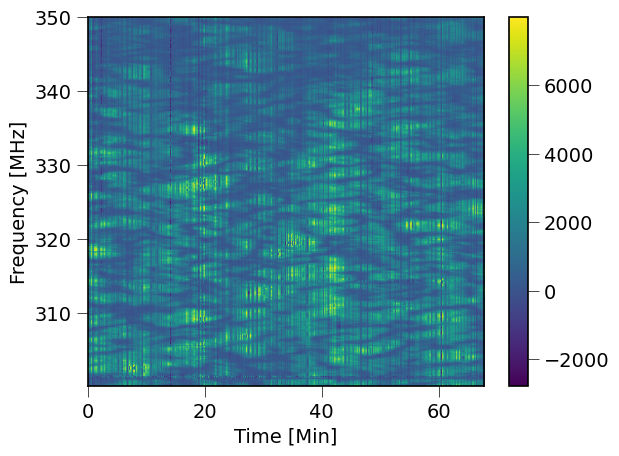

In [13]:
plt.imshow(a,aspect = 'auto',extent=[0.0, subint*a.shape[1]/60, cfreq-(bw/2),cfreq+bw/2]);
plt.xlabel("Time [Min]")
plt.ylabel("Frequency [MHz]")
plt.colorbar(); plt.show()

# Section 3: Modulation Index Calculation

Now we will determine the modulation index (effectively, the degree to which the dynamic spectrum fluctuates). From [Ocker et al. (2023) ](https://arxiv.org/pdf/2309.13809): 

"Arc properties can be evaluated in the context of weak and strong scintillation, which correspond to the regimes where the modulation index (rms intensity variation / mean intensity) is $m \ll 1$ and $m \sim 1$, respectively."

The modulation index for some variable $x$ is given by  <h1><center>$m_\textrm{b} = \frac{1}{\langle x\rangle}\Bigg(\frac{1}{N_{\textrm{x}}} \sum_{i = 1}^{N_{\textrm{x}}}\big(x_i-\langle x \rangle \big)^2 \Bigg)^{1/2}$</center></h1>.

Use the space below to calculate this for your observations.

In [14]:
# m_b = 0
# x_expect = np.mean(a)
# inv_x_expect = (1 / x_expect)
# N_X = len(a) * len(a[0])
# inv_N_X = (1 / N_X)
# sum_dev = 0
# for i in a:
#     for j in i:
#         x = j
#         dev = (x - x_expect) ** 2
#         sum_dev += dev

# m_b = (inv_x_expect) * (((inv_N_X) * (sum_dev)) ** 0.5)
# print(m_b)


def modulation_index(a):
    total_sum_dev = 0
    x_expect = np.mean(a)
    inv_x_expect = (1 / x_expect)
    N_X = len(a.flatten())
    inv_N_X = (1 / N_X)
    total_sum_dev = np.sum((a.flatten() - x_expect) ** 2)
    m_b = (inv_x_expect) * (((inv_N_X) * (total_sum_dev)) ** 0.5)
    return m_b

obs1_m_b = modulation_index(a)
print(obs1_m_b)

0.8985984653936558


# Section 4: Create and Examine Secondary Spectrum

Create the secondary spectrum 
via 2D Fourier transform. 
You don't need to change anything here,
but feel free to ask me questions about anything
here if you're curious!

In [15]:
b = a.T
naxis2 = a.shape[0]
nchans = a.shape[1]
nyq_t = 1000. / (2. * t_int) #nyquist limit for the fringe frequency axis of the secondary spectrum
nyq_f = nchans / (2. * BW) #nyquist limit for the delay axis of the secondary spectrum
fringe = np.linspace(-nyq_t,nyq_t,naxis2)
x_axis=fringe
x_axis_e4=[int(10000*x) for x in x_axis]
get_x_axis= [x/10000. for x in x_axis_e4]
delay = np.linspace(0,nyq_f,int(nchans/2.))
y_axis=delay
y_axis_e4=[int(10000*y) for y in y_axis][::-1]
get_y_axis=[y/10000. for y in y_axis_e4]
axis_x = get_x_axis
axis_y = np.abs(get_y_axis)
spin=np.rot90(b)
dynamic = spin - np.mean(spin)
sec_init = np.fft.fftn(dynamic)
secondary=10.*np.log10(np.abs(np.fft.fftshift(sec_init))**2)
ysize = secondary.shape[0]
xsize = secondary.shape[1]
xmin = int(xsize/2. - xsize/(2.))
xmax = int(xsize/2. + xsize/(2.))
ymin = int(ysize/2. - ysize/(2.))
ymax = int(ysize/2. + ysize/(2))
secondary=secondary[ymin:ymax,xmin:xmax]
(x_min,x_max) = (min(axis_x),max(axis_x))
(y_min,y_max) = (-max(axis_y),max(axis_y))
ymin = freq_main - BW/(2.)
ymax = freq_main + BW/(2.)
xmin = int(xsize/2. - xsize/(2.))
xmax = t_int*xsize/60

Plot the secondary spectrum

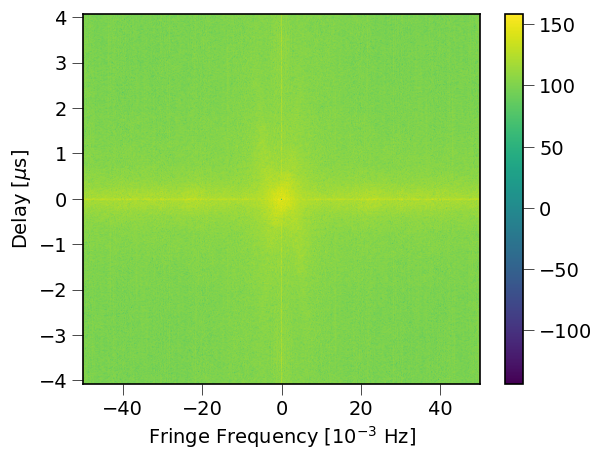

In [16]:
dsplot = plt.imshow(secondary,aspect='auto',extent=[x_min,x_max,y_min,y_max])
plt.colorbar()
# plt.ylim(0,7)
plt.ylabel(r'Delay [$\mu$s]')
plt.xlabel(r'Fringe Frequency [10$^{-3}$ Hz]')
plt.show()

Play around with the value on the line below to try and make the arcs clearer.
Try and compare the pixel values of the arcs on the colorbar
to the values of the background. 70 to 80 seems to be a good range to start. If you think you went too far, you just need to go back to the cell where you created the secondary spectrum. 

In [17]:
secondary[secondary<85] = np.median(secondary)

Plot the secondary spectrum
to see how many arcs you should expect to fit. Don't forget to give it the "squint test"!

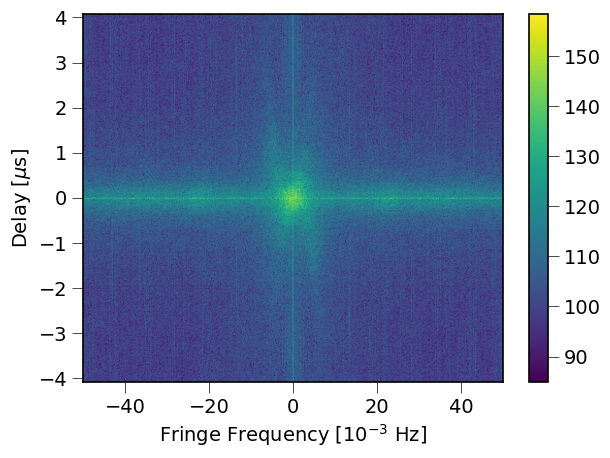

In [19]:
dsplot = plt.imshow(secondary,aspect='auto',extent=[x_min,x_max,y_min,y_max])
plt.colorbar()
# plt.ylim(0,7)
plt.ylabel(r'Delay [$\mu$s]')
plt.xlabel(r'Fringe Frequency [10$^{-3}$ Hz]')
plt.tight_layout()
# plt.savefig('Figures/J1136+1551_%s_%s_%s_Secondary.pdf'%(str(mjd),str(cfreq),rfi_cleaned),)
# plt.show()

# Section 5: Use `scintools` to Obtain Scintillation Arc Curvatures

Use this space (and any additional cells you need) 
to create code to run commands from scintools and 
extract arc curvatures. Feel free to play around with
the various functions, but I recommend against
using the `correct_dyn()` function, as it seems
to mess up these data. See tutorial notebook for reference
https://github.com/danielreardon/scintools/blob/master/scintools/examples/arc_modelling.ipynb

To actually get the curvature values from the fits, use
`dyn.betaeta` to get the curvature 
and `dyn.betaetaerr` to get the curvature error

Load the dynamic spectrum class

In [ ]:
from dynspec import Dynspec

Load the .txt file that corresponds 
to the .pickle file you just looked at.
Variables are already defined from earlier, 
so no need to change anything.

In [ ]:
dyn = Dynspec(filename='60098_files/J1136+1551_%s_%s_%s.txt'%(str(mjd),str(cfreq),rfi_cleaned), process=True) 

Use the space below (and any additional cells
you need) to process the dynamic spectrum and
fit arc curvatures!

In [ ]:
#Plot dynamic spectrum 
dyn.plot_dyn(filename='Figures/J1136+1551_%s_%s_%s_Dynamic.pdf'%(str(mjd),str(cfreq),rfi_cleaned))


In [ ]:
dyn.scale_dyn()
dyn.plot_dyn(lamsteps=True)

In [ ]:
dyn.plot_sspec(lamsteps=True)

In [ ]:
dyn.fit_arc(
    lamsteps=True,
    plot=True,
    etamin=50,
    etamax=1000,
    delmax=3,
    numsteps=1e3,
    nsmooth=7,
    startbin=2,
)


In [ ]:
dyn.plot_sspec(lamsteps=True, plotarc=True)

In [ ]:
print("Curvature measurement:", round(dyn.betaeta, 1))
print("Curvature uncertainty:", round(dyn.betaetaerr, 1))

In [ ]:
dyn.norm_sspec(lamsteps=True, plot=True, delmax=3, cutmid=5, startbin=1)

# Section 6: Obtain Arc Curvature Scaling Indices 

Once you've fit an arc, acquire the normalized secondary spectrum and power spectrum. Once you've modified the scintools script, you can use this function to acquire the x- and y-axis arrays for the power spectrum that you will be using to measure power laws! Make sure to modifty the `startbin` and `delmax` values accordingly depending on how your scintillation arcs look and how far up the delay axis your arcs are visible! The `tdel` variable stands for time delay, by the way. If you have multiple arcs, I think you should try and modify the next few cells so that you can plot all arcs on the same power law fit plot!

In [ ]:
def arc_curvature():
    tdel,powerspectrum = dyn.norm_sspec(lamsteps=True, plot=True, delmax=3, cutmid=5, startbin=1)
    return tdel, powerspectrum

tdel1, powerspectrum1 = arc_curvature()
plt.loglog(tdel1[35:], powerspectrum1[35:])



Now we can finally fit our power spectrum to determine the spectral index! To make it easier on the fitting algorithm, we will be doing the fit by first converting our values to log space and then converting everything back once the fit is complete. Make sure to pay close attention to how far off these power laws are from what we'd expect under Kolmogorov turbulence ($\alpha \approx -2.33$). It would be useful to also have a line showing this Kolmogorov power law behavior for comparison. You may need to adjust how much of the array you use for the fits depending on when the signal flattens out. We're looking for equations of the form $A x^{\alpha}$. Make sure and save the image when you're done.

In [3]:
#Fit power spectrum

tdel1_cut = tdel1[35:]
powerspectrum1_cut = powerspectrum1[35:]

log_tdel1 = np.log(tdel1_cut)
log_powerspectrum1 = np.log(powerspectrum1_cut)

# coeffs = np.polyfit(log_tdel1, log_powerspectrum1, 1)
a, A, r, p, std = stats.linregress(log_tdel1, log_powerspectrum1)
# a = coeffs[0]
# A = coeffs[1]

tdel1_fit = np.linspace(min(tdel1), max(tdel1), 100)
log_tdel1_fit = np.log(tdel1_fit)
powerspectrum1_fit = np.exp(a * log_tdel1_fit + A)

#Kolmogrov Turbulence
alpha = -2.33
tdel1_fit_alpha = np.linspace(min(tdel1), max(tdel1), 100)
log_tdel1_fit_alpha = np.log(tdel1_fit_alpha)
powerspectrum1_fit_alpha = np.exp(alpha * log_tdel1_fit_alpha + A)



plt.loglog(tdel1[35:], powerspectrum1[35:])
plt.plot(tdel1_fit[3:], powerspectrum1_fit[3:], 'r--', label= "\u03B1 = {} \u00B1 {}".format(round(a, 2), round(std, 4)))
plt.plot(tdel1_fit_alpha[3:], powerspectrum1_fit_alpha[3:], 'r-', label= "Kolomogrov")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$f_{\lambda}$ (m$^{-1}$)")
plt.ylabel(r"$S_{2}$ $f_{\lambda}$")
plt.legend()
plt.tight_layout()
plt.savefig('Figures/J1136+1551_%s_%s_%s_Power_Law_Fit.pdf'%(str(mjd),str(cfreq),rfi_cleaned))
np.savetxt('Figures/J1136+1551_%s_%s_%s_tdel1.txt'%(str(mjd),str(cfreq),rfi_cleaned), tdel1_cut)
np.savetxt('Figures/J1136+1551_%s_%s_%s_powerspectrum1.txt'%(str(mjd),str(cfreq),rfi_cleaned), powerspectrum1_cut) 
np.savetxt('Figures/J1136+1551_%s_%s_%s_tdel1_fit.txt'%(str(mjd),str(cfreq),rfi_cleaned), tdel1_fit)
np.savetxt('Figures/J1136+1551_%s_%s_%s_powerspectrum1_fit.txt'%(str(mjd),str(cfreq),rfi_cleaned), powerspectrum1_fit) 

NameError: name 'tdel1' is not defined

In [84]:
#Curvature Calculation/Conversion
def eta_calc():
    eta_c = round(dyn.betaeta, 1)
    freq = 1400 
    c = scipy.constants.c
    calc = ((eta_c * c) / (freq ** 2))
    calc_secs = calc * 1e-6
    return calc_secs
print(eta_calc())


0.016289743253571427
